In [1]:
import cv2
import torch

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from torch.utils.data import DataLoader
from tqdm import tqdm

from train2 import FCModel, CNNModel, ResCNN1DLayer, FPathDataset
from src.dataloaders import FPathLazyDataset
from src.utils import calculate_noise_metric

### Model Load

In [2]:
# CNNModel
path = "/home/work/joono/VTFSketch/weights/best_CNNModel_acc79.57.pth"
model = torch.load(path)

# FCModel
# model = torch.load("/home/work/joono/VTFSketch/weights/best_FCModel_acc77.46.pth")

model = model.to('cuda')
model = model.eval()

### Calculate test accuracy

In [3]:
test_dset = FPathDataset("/home/work/joono/VTFSketch/dataset/test.npz")
test_dloader = DataLoader(test_dset, batch_size=40960, num_workers=24)


preds_list, targets_list = [], []
with torch.no_grad():
    for fpath, target in tqdm(test_dloader):
        fpath, target = fpath.to('cuda'), target.to('cuda')
        y_hat = model(fpath)

        targets_list.append(target.detach().cpu().numpy())
        preds_list.append(y_hat.detach().cpu().numpy())

preds = np.concatenate(preds_list).flatten()
targets = np.concatenate(targets_list).flatten()

metric = calculate_noise_metric(preds=preds, targets=targets)


100%|██████████| 142/142 [00:04<00:00, 32.87it/s]


In [4]:
metric

{'accuracy': 0.784999422839708,
 'f1score': 0.6051071783627074,
 'recall': 0.5465856503017503,
 'confusion_matrix': array([[3594866,  454108],
        [ 791953,  954690]])}

Text(50.722222222222214, 0.5, 'True Label')

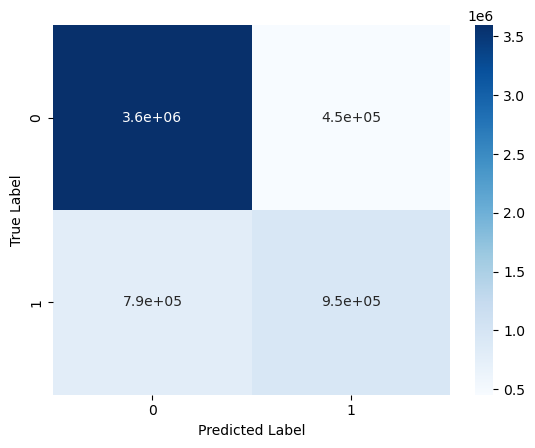

In [5]:
sns.heatmap(metric['confusion_matrix'], annot=True, cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Test using dataset

In [6]:
dset = FPathLazyDataset(config_path="/home/work/joono/VTFSketch/dataset/test.yaml")

In [7]:
fpath, _, infodraw, target = dset[2]

print(f"fpath: {type(fpath), fpath.shape}, infodraw: {type(infodraw), infodraw.shape}, target: {type(target), target.shape}")

fpath_tensor = torch.tensor(fpath).unsqueeze(0)
infodraw_tensor = torch.tensor(infodraw).unsqueeze(0)
target_tensor = torch.tensor(target).unsqueeze(0)

fpath_tensor = fpath_tensor.to('cuda')
infodraw_tensor = infodraw_tensor.to('cuda')
target_tensor = target_tensor.to('cuda')

print(f"fpath_tensor: {type(fpath_tensor), fpath_tensor.shape}, infodraw: {type(infodraw_tensor), infodraw_tensor.shape}, target_tensor: {type(target_tensor), target_tensor.shape}")

fpath: (<class 'numpy.ndarray'>, (21, 1024, 1024)), infodraw: (<class 'torch.Tensor'>, torch.Size([1, 1024, 1024])), target: (<class 'torch.Tensor'>, torch.Size([1, 1024, 1024]))
fpath_tensor: (<class 'torch.Tensor'>, torch.Size([1, 21, 1024, 1024])), infodraw: (<class 'torch.Tensor'>, torch.Size([1, 1, 1024, 1024])), target_tensor: (<class 'torch.Tensor'>, torch.Size([1, 1, 1024, 1024]))


/tmp/ipykernel_1174600/3010904649.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  infodraw_tensor = torch.tensor(infodraw).unsqueeze(0)
/tmp/ipykernel_1174600/3010904649.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_tensor = torch.tensor(target).unsqueeze(0)


# Test using wild image

In [8]:
from src.preprocesses import VTFPreprocessor, ImagePreprocessor, InfodrawPreprocessor

In [9]:
vtf_path = "/home/work/joono/VTFSketch/dataset/hard_data/vtfs/simple_curve_fpath_of_infodraw.npz"
infodraw_path = "/home/work/joono/VTFSketch/dataset/hard_data/infodraws/simple_curve_out.png"

fpath      = VTFPreprocessor.get(vtf_path)
infodraw  = InfodrawPreprocessor.get(infodraw_path)

fpath_tensor = torch.tensor(fpath).unsqueeze(0).to('cuda')
infodraw_tensor = torch.tensor(infodraw).unsqueeze(0).to('cuda')

/tmp/ipykernel_1174600/1736704625.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  infodraw_tensor = torch.tensor(infodraw).unsqueeze(0).to('cuda')


# Inference

In [10]:
model = model.to('cuda')

_, _, H, W = infodraw_tensor.shape

result = infodraw_tensor.clone()

target_indices = torch.where(infodraw_tensor < 0.99)
selected_fpath_tensor = fpath_tensor[target_indices[0], :, target_indices[2], target_indices[3]]
print(f"selected_fpath_tensor: {selected_fpath_tensor.shape}")

with torch.no_grad():
    y_hat = model(selected_fpath_tensor)

y_hat = y_hat.squeeze()

for i, (b, c, h, w) in enumerate(zip(target_indices[0], target_indices[1], target_indices[2], target_indices[3], )):
    result[b, c, h, w] = y_hat[i]

selected_fpath_tensor: torch.Size([6077, 21])


In [11]:
np_result = result.squeeze().detach().cpu().numpy()

True

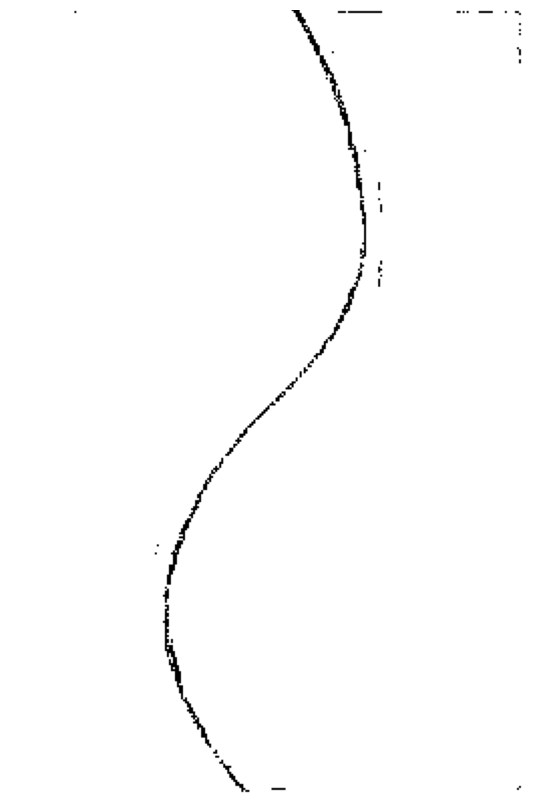

In [12]:
plt.figure(figsize=(10.24, 10.24))
plt.imshow(np_result > 0.5, cmap='gray')
plt.axis('off')
cv2.imwrite("test_FC_903.png", 255 * np.array(np_result > 0.5, dtype=np.float32))

(-0.5, 255.5, 391.5, -0.5)

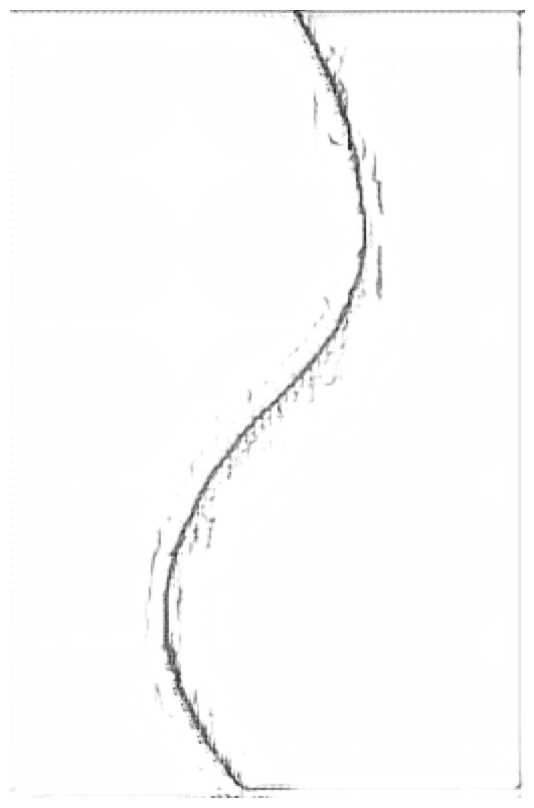

In [13]:
plt.figure(figsize=(10.24, 10.24))
plt.imshow(infodraw.squeeze(), cmap='gray')
plt.axis('off')

In [14]:
model = model.to('cuda')

_, _, H, W = infodraw_tensor.shape

result = infodraw_tensor.clone()
with torch.no_grad():
    for h in tqdm(range(H)):
        for w in range(W):
            if infodraw_tensor[0, 0, h, w] < 0.99:
                y_hat = model(fpath_tensor[0, :, h, w].unsqueeze(0))
                result[0, 0, h, w] = y_hat

100%|██████████| 392/392 [00:05<00:00, 67.11it/s]


In [15]:
np_result = result.squeeze().detach().cpu().numpy()

(-0.5, 255.5, 391.5, -0.5)

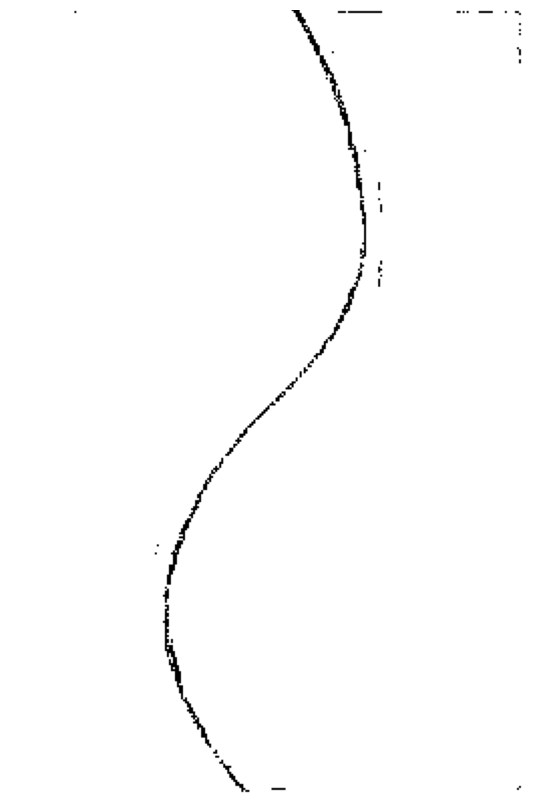

In [16]:
plt.figure(figsize=(10.24, 10.24))
plt.imshow(np_result > 0.5, cmap='gray')
plt.axis('off')